In [2]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
from matplotlib.animation import FuncAnimation

# 1. Configuración de la simulación
---

In [3]:
def setup_simulation(a=1.0, e=0.1, inc_deg=30, perturba=False):
    """Crea un sistema de 2 cuerpos en 3D con/sin perturbación inicial.
    
    Parámetros:
    - a: semieje mayor
    - e: excentricidad
    - inc_deg: inclinación en grados
    - perturba: si se aplica una perturbación pequeña
    """
    sim = rebound.Simulation()
    sim.units = ('AU', 'yr', 'Msun')
    sim.add(m=1.0)  # Estrella central
    
    # Perturbación para cálculo de Lyapunov
    delta = 1e-6 if perturba else 0.0
    # Convertir inclinación a radianes
    inc = np.deg2rad(inc_deg)
    sim.add(m=1e-3, a=a + delta, e=e + delta, inc=inc)  # Planeta en 3D
    
    sim.integrator = "ias15"
    sim.dt = 0.01
    return sim

# 2. Simulación y recolección de datos
---

In [4]:
def run_simulation(t_max=1e3, N_steps=1000, inc_deg=30):
    # Simulación nominal
    sim_nominal = setup_simulation(a=1.0, e=0.1, inc_deg=inc_deg)
    times = np.linspace(0, t_max, N_steps)
    
    # Arrays para almacenar datos de elementos orbitales
    a_arr, e_arr, energy = np.zeros(N_steps), np.zeros(N_steps), np.zeros(N_steps)
    
    # Simulación perturbada (para Lyapunov)
    sim_perturbed = setup_simulation(a=1.0, e=0.1, inc_deg=inc_deg, perturba=True)
    a_pert, e_pert = np.zeros(N_steps), np.zeros(N_steps)
    
    # Arrays adicionales para animación en 3D: x, y, z
    x = np.zeros((N_steps, 2))
    y = np.zeros((N_steps, 2))
    z = np.zeros((N_steps, 2))
    
    for i, t in enumerate(times):
        # Integrar ambas simulaciones
        sim_nominal.integrate(t)
        sim_perturbed.integrate(t)
        
        # Calcular elementos orbitales usando rebound.Orbit
        orbit_nominal = sim_nominal.particles[1].orbit(sim_nominal.particles[0])
        a_arr[i], e_arr[i] = orbit_nominal.a, orbit_nominal.e
        
        orbit_perturbed = sim_perturbed.particles[1].orbit(sim_perturbed.particles[0])
        a_pert[i], e_pert[i] = orbit_perturbed.a, orbit_perturbed.e
        
        # Energía del sistema
        energy[i] = sim_nominal.energy()
        
        # Almacenar posiciones 3D para animación
        for j in [0, 1]:
            x[i, j] = sim_nominal.particles[j].x
            y[i, j] = sim_nominal.particles[j].y
            z[i, j] = sim_nominal.particles[j].z
    
    return times, a_arr, e_arr, energy, a_pert, e_pert, x, y, z


# 3. Cálculo de métricas de estabilidad
---

In [5]:
def calculate_stability(times, a_arr, e_arr, energy, a_pert, e_pert):
    # Estabilidad orbital
    delta_a = np.max(a_arr) - np.min(a_arr)
    delta_e = np.max(e_arr) - np.min(e_arr)
    
    # Divergencia y ajuste de Lyapunov (solo en fase lineal)
    delta_orbit = np.sqrt((a_arr - a_pert)**2 + (e_arr - e_pert)**2)
    
    # Limitar a la fase de crecimiento inicial (evitar overflow)
    cutoff = np.argmax(delta_orbit > 1e-3)  # Ajusta este valor según tus datos
    valid = (delta_orbit > 0) & (delta_orbit < 1e-3) & (times < times[cutoff] if cutoff else True)
    
    λ = np.nan
    if np.sum(valid) > 10:  # Mínimo de puntos para ajuste
        #def model(t, λ):
        #    return delta_orbit[valid][0] * np.exp(λ * t) produce warnings por numeros extremadamente pequeños o grandes
        def model(t, λ):
            return delta_orbit[valid][0] * np.exp(np.clip(λ * t, -100, 100))

        
        try:
            params, _ = curve_fit(model, times[valid], delta_orbit[valid], maxfev=5000)
            λ = params[0]
        except:
            pass
    
    # Energía relativa
    energy_rel = np.abs((energy - energy[0])/energy[0])
    
    return {
        "delta_a": delta_a,
        "delta_e": delta_e,
        "lyapunov": λ,
        "energy_var": np.max(energy_rel)
    }

# 4. Visualización
---

In [6]:
def plot_analysis(times, a_arr, e_arr, energy, a_pert, e_pert, metrics):
    fig, axs = plt.subplots(3, 2, figsize=(15, 10))
    
    # Órbita: Semieje mayor
    axs[0,0].plot(times, a_arr, 'b')
    axs[0,0].set_title(f"Semieje Mayor (Δa = {metrics['delta_a']:.2e} AU)")
    axs[0,0].set_ylabel("a (AU)")
    
    # Órbita: Excentricidad
    axs[0,1].plot(times, e_arr, 'r')
    axs[0,1].set_title(f"Excentricidad (Δe = {metrics['delta_e']:.2e})")
    axs[0,1].set_ylabel("e")
    
    # Energía
    axs[1,0].semilogy(times, np.abs((energy - energy[0])/energy[0]), 'g')
    axs[1,0].set_title(f"Energía Relativa (Máx: {metrics['energy_var']:.2e})")
    axs[1,0].set_ylabel("|ΔE/E₀|")
    
    # Lyapunov
    axs[1,1].semilogy(times, np.sqrt((a_arr - a_pert)**2 + (e_arr - e_pert)**2), 'm')
    axs[1,1].set_title(f"Exponente de Lyapunov: λ = {metrics['lyapunov']:.2e}")
    axs[1,1].set_ylabel("Divergencia")
    
    # Resumen de estabilidad
    axs[2,0].axis('off')
    summary_text = (
        "Resumen de Estabilidad:\n"
        f"1. Variación Orbital: Δa = {metrics['delta_a']:.2e} AU, Δe = {metrics['delta_e']:.2e}\n"
        f"2. Exponente de Lyapunov: λ = {metrics['lyapunov']:.2e} (λ > 0 → Caótico)\n"
        f"3. Variación de Energía: {metrics['energy_var']:.2e}"
    )
    axs[2,1].text(0.1, 0.5, summary_text, fontsize=12)
    axs[2,1].axis('off')
    
    plt.tight_layout()
    plt.show()

# 5. Animación 3D
---

In [7]:
def animate_trajectory(x, y, z, times, save_path=None, save_format="gif"):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Configuración inicial de los ejes
    max_range = max(np.max(np.abs(x)), np.max(np.abs(y)), np.max(np.abs(z))) * 1.1
    ax.set_xlim(-max_range, max_range)
    ax.set_ylim(-max_range, max_range)
    ax.set_zlim(-max_range, max_range)
    ax.set_xlabel("X (AU)")
    ax.set_ylabel("Y (AU)")
    ax.set_zlabel("Z (AU)")

    # Inicialización de los objetos con la posición del primer frame
    star = ax.scatter(x[0, 0], y[0, 0], z[0, 0], c='gold', s=100, label='Estrella')
    planet = ax.scatter(x[0, 1], y[0, 1], z[0, 1], c='blue', s=30, label='Planeta')
    trail, = ax.plot([], [], [], 'b--', alpha=0.5)

    ax.legend()
    
    #print("X Pos planeta: ", x[:, 1])

    def update(frame):
        star._offsets3d = ([x[frame, 0]], [y[frame, 0]], [z[frame, 0]])
        planet._offsets3d = ([x[frame, 1]], [y[frame, 1]], [z[frame, 1]])

        start = max(0, frame - 300)  # La trayectoria dura 300 frames

        # Calculamos alpha: Se desvanece progresivamente
        alpha = max(0.2, 1 - (frame / len(times)))  # Nunca baja de 0.2 para que siempre sea visible

        trail.set_data(x[start:frame+1, 1], y[start:frame+1, 1])
        trail.set_3d_properties(z[start:frame+1, 1])
        trail.set_alpha(alpha)  # Aplicar transparencia dinámica

        ax.set_title(f"Tiempo: {times[frame]:.1f} años")
        return star, planet, trail

    ani = FuncAnimation(fig, update, frames=len(times), interval=20, blit=False)

    if save_path:
        if save_format == "gif":
            ani.save(save_path, writer=PillowWriter(fps=30))
        elif save_format == "mp4":
            ani.save(save_path, writer=FFMpegWriter(fps=30))

    plt.show()


# 5. Ejecución principal
---

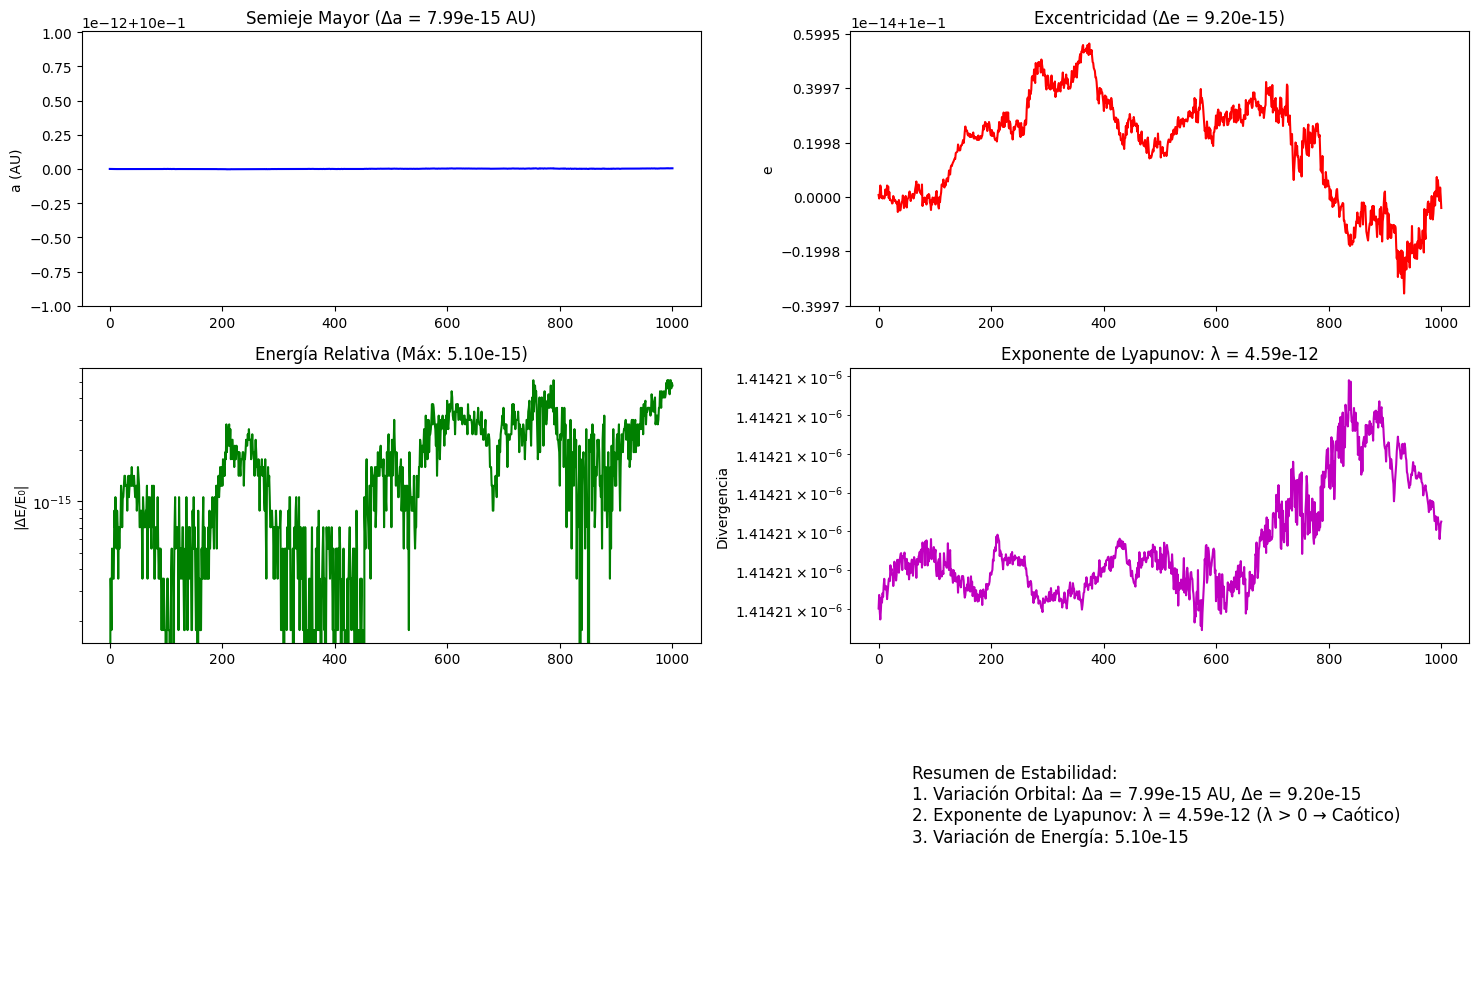

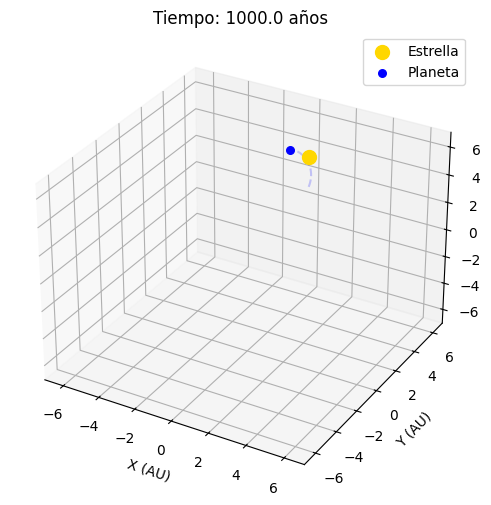

In [8]:
if __name__ == "__main__":
    # Parámetros de simulación
    t_max = 1e3  # Años
    N_steps = 1000
    inc_deg = 30  # Inclinación en grados para la órbita del planeta
    
    # Ejecutar simulación
    times, a_arr, e_arr, energy, a_pert, e_pert, x, y, z = run_simulation(t_max, N_steps, inc_deg)
    
    # Calcular métricas
    metrics = calculate_stability(times, a_arr, e_arr, energy, a_pert, e_pert)
    
    # Generar gráficos de análisis
    plot_analysis(times, a_arr, e_arr, energy, a_pert, e_pert, metrics)
    
    # Generar animación 3D (en ventana separada)
    animate_trajectory(x, y, z, times, save_path="trayectoria.gif", save_format="gif")